# Channel Pruning with PIT


## Requirements

Install requirements for this and other examples as follows:
```bash
pip install -r <plinio_folder>/examples/requirements.txt
```

## Content

This notebook shows how to use PLiNIO to apply structured channel pruning to a CNN model, using the PIT algorithm described in [this](https://arxiv.org/abs/2301.10281) paper. Note that, for Temporal Convolutional Networks (TCNs) PIT can also be used to optimize the kernel size and dilation of convolutional layers. However, here we focus on the more common case of channel pruning for 2D CNNs.

PIT uses a mask-based approach. During training, it learns to mask out unimportant channels for each layer, effectively eliminating them from the network. The working principle is schematized in the following picture:

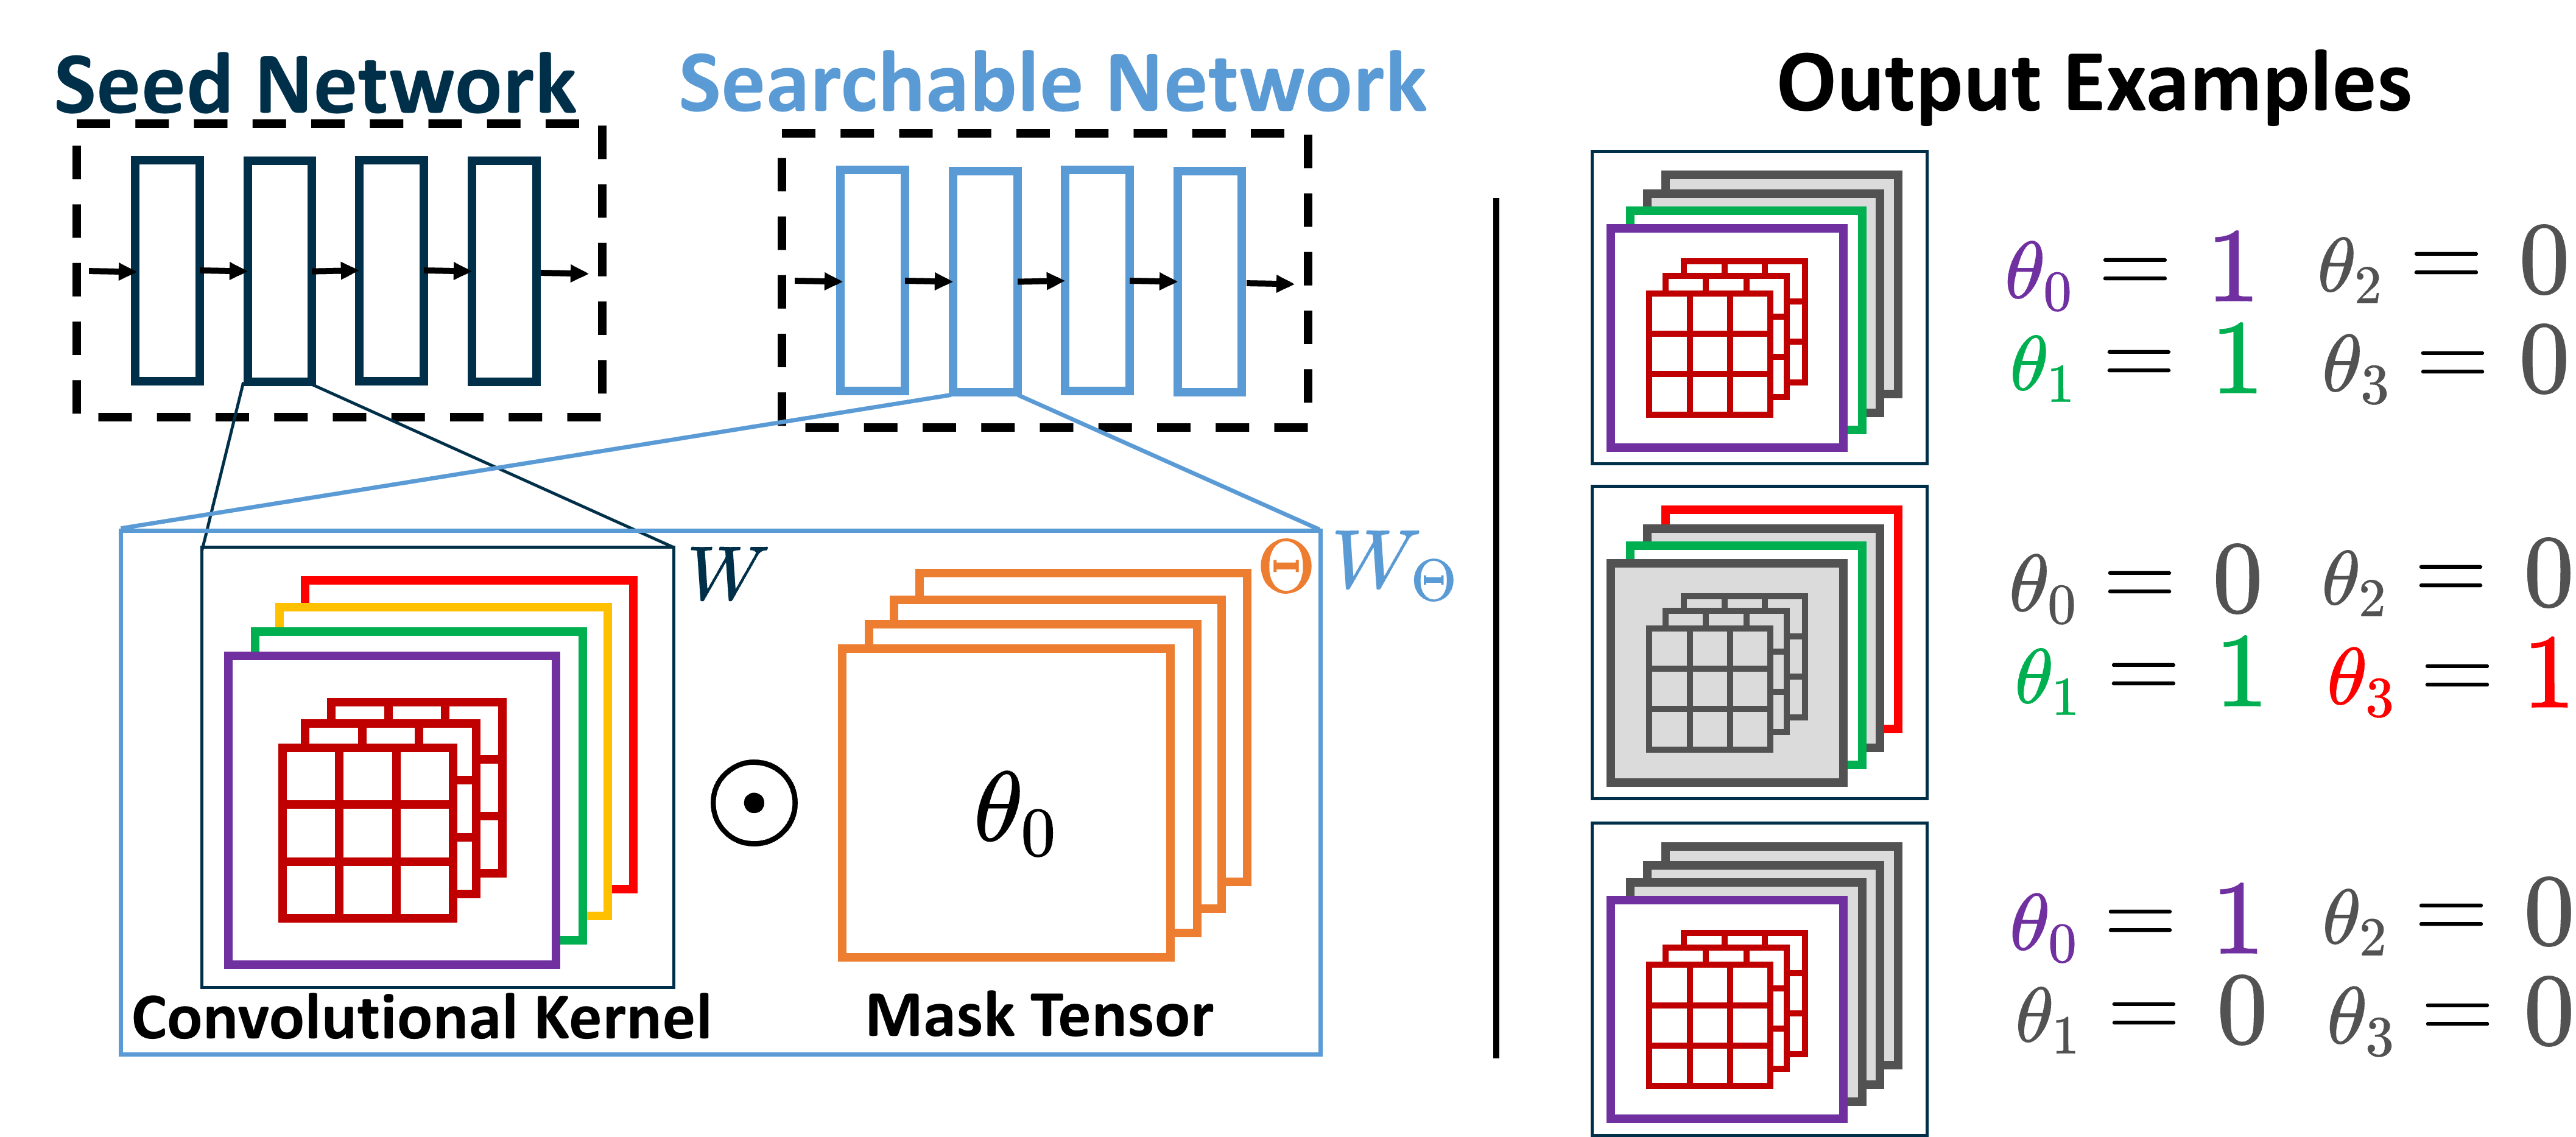

The "seed" DNN (a standard network) is turned into a "searchable" DNN by associating each supported layer (convolutional or linear) with a new set of trainable *binary* parameters $\theta$. Each $\theta_i$ is associated with a single weight filter/neuron, and functions as a mask. When it is set to $\theta_i=1$, the filter/neuron is kept, whereas, when it is set to $\theta_i =0 $ it is removed from the layer's output. Thus, the corresponding output activation channel is effectively eliminated.

The $\theta$ values are trained with gradient-descent together with the normal weights of the network. In practice, what is actually trained are continuous parameters $\alpha$, from which $\theta$ binary masks are obtained through a step function ($\theta_i = \mathcal{H}(\alpha_i)$). The training goal is to optimize a combined loss function in the form:

$$
\mathcal{L}_{tot}(W,\theta) = \mathcal{L}_{task}(W,\theta) + \lambda \mathcal{L}_{cost}(\theta)
$$

where $\mathcal{L}_{task}$ is the standard task-loss (e.g. cross-entropy), while $\mathcal{L}_{cost}$ encodes the cost of the network (e.g. params, ops, or hardware-dependent latency/energy) and $\lambda$ is a scalar regularization strength.

## 1) Setup

We start by importing required libraries:
- The `PIT` class from `plinio.methods` implements the required structured pruning.
- The `params` class from `plinio.cost` implements the cost model used in this example (model size).

In [1]:
import os
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader

import torchvision
import torchvision.transforms as transforms

# for loss/metrics logging
from torcheval.metrics import MulticlassAccuracy, Mean

# for progress bar visualization
from tqdm import tqdm

from torchinfo import summary

from plinio.cost import params
from plinio.methods import PIT

from utils.train import set_seed
from utils.plot import plot_learning_curves, plot_learning_curves_nas

Next, we define training configurations and set basic options and paths. Note that these are not state-of-the-art settings for the CIFAR-10 dataset, and superior accuracy results can be obtained with more advanced training recipes. However, the goal is to keep this notebook as simple as possible.

In [2]:
TRAINING_CONFIG = {
    'val_split': 0.2,           # validation spli
    'epochs': 100,              # max epochs for warmup
    'search_epochs': 100,       # max epochs for the search phase
    'finetune_epochs': 50,      # max epochs for the finetuning phase
    'batch_size': 32,           # batch size
    'lr': 0.01,                 # initial learning rate for warm up
    'search_lr_net': 0.001,     # learning rate for DNN weights during the search phase
    'search_lr_mask': 0.0005,   # learning rate for mask parameters during the search phase
    'finetune_lr': 0.001,       # learning rate for the final fine-tuning.
    'weight_decay': 1e-4,       # weight decay for normal DNN parameters
    'patience': 10,             # early-stopping patience for normal trainings
    'search_patience': 50,      # early-stopping patience for the search phase
}

DATA_DIR = Path("channel_pruning_pit")
SAVE_DIR = DATA_DIR / "local_checkpoints"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(SAVE_DIR, exist_ok=True)

set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Working on: {device}")

Working on: cuda:0


## 2) Dataset and Model Preparation

Next, we download the CIFAR-10 dataset and create dataloaders:

In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_val_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR / "data",
                                                 train=True, download=True, transform=transform_train)
val_len = int(TRAINING_CONFIG['val_split'] * len(train_val_dataset))
train_len = len(train_val_dataset) - val_len
train_dataset, val_dataset = random_split(train_val_dataset, [train_len, val_len])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=False)


test_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR / "data",
                                            train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=False)

And define a simple mini-ResNet CNN model. 

**IMPORTANT**: Note that this is pure PyTorch code, no modifications are required by PLiNIO at this stage:

In [4]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class MiniResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MiniResNet, self).__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = BasicBlock(16, 32, stride=2)
        self.layer2 = BasicBlock(32, 64, stride=2)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

Create an instance of the model and print its structure with `torchinfo`:

In [5]:
model = MiniResNet().to(device)

# compute the shape of a single DNN input
input_shape = train_dataset[0][0].numpy().shape
# show the network summary (requires a 1-input batch)
print(summary(model, (1,) + input_shape, depth=5))

Layer (type:depth-idx)                   Output Shape              Param #
MiniResNet                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 32, 32]           432
├─BatchNorm2d: 1-2                       [1, 16, 32, 32]           32
├─ReLU: 1-3                              [1, 16, 32, 32]           --
├─BasicBlock: 1-4                        [1, 32, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 32, 16, 16]           4,608
│    └─BatchNorm2d: 2-2                  [1, 32, 16, 16]           64
│    └─ReLU: 2-3                         [1, 32, 16, 16]           --
│    └─Conv2d: 2-4                       [1, 32, 16, 16]           9,216
│    └─BatchNorm2d: 2-5                  [1, 32, 16, 16]           64
│    └─Sequential: 2-6                   [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-1                  [1, 32, 16, 16]           512
│    │    └─BatchNorm2d: 3-2             [1, 32, 16, 16]           64
│    └─

/home/daniele/Documents/code-git/plinio-devel/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## 3) Warm Up (Optional)

**IMPORTANT**: Again, this is just (very basic) PyTorch training code. If you want to jump directly to PLiNIO optimizations (Part 3), you can skip this part and simply load a pre-cooked checkpoint with this line.

```python
model.load_state_dict(torch.load("./channel_pruning_pit/checkpoints/warmup_best.pt"))
```

Pruning works better starting from a pre-trained model. So, let's start by defining a simple ResNet8 CNN and training it on a few epochs on CIFAR-10. Alternatively, you can download pre-trained weights (e.g. on ImageNet), possibly fine-tuning them for a few epochs on CIFAR-10.

Let's define a simple training loop. 

In [6]:
# function to train the model for one epoch 
def train_one_epoch(epoch, model, criterion, optimizer, data, device):
    model.train()
    loss_metric = Mean()
    acc_metric = MulticlassAccuracy(num_classes=10)
    loop = tqdm(data, desc=f"Epoch {epoch+1}")
    for i, (images, labels) in enumerate(loop):
        images, labels = images.to(device), labels.to(device)
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # backward pass and weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # log metrics
        loss_metric.update(loss.detach().cpu())
        acc_metric.update(outputs.detach().cpu(), labels.detach().cpu())
        if i % 100 == 99:
            avg_loss = loss_metric.compute().item()
            avg_acc = acc_metric.compute().item() * 100
            loop.set_postfix(loss=avg_loss, accuracy=avg_acc)
    final_metrics = {
        'loss': loss_metric.compute().item(),
        'acc': acc_metric.compute().item() * 100,
    }
    return final_metrics

# function to evaluate the model for one epoch
def evaluate(model, criterion, data, device):
    model.eval()
    loss_metric = Mean()
    acc_metric = MulticlassAccuracy(num_classes=10)
    with torch.no_grad():
        loop = tqdm(data, desc=f"Evaluation")
        for i, (images, labels) in enumerate(loop):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_metric.update(loss.detach().cpu())
            acc_metric.update(outputs.cpu(), labels.cpu())
            if i == len(data) - 1:
                avg_loss = loss_metric.compute().item()
                avg_acc = acc_metric.compute().item() * 100
                final_metrics = {
                    'loss': avg_loss,
                    'acc': avg_acc,
                }
                loop.set_postfix(loss=avg_loss, accuracy=avg_acc)
    return final_metrics

# global training loop
def train(checkpoint_path, patience, epochs, model, criterion, optimizer, scheduler, train_loader, val_loader, device):
    # Early stopping and checkpointing
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    history = []
    for epoch in range(epochs):
        metrics = train_one_epoch(epoch, model, criterion, optimizer, train_loader, device)
        val_metrics = evaluate(model, criterion, val_loader, device)
        # rename val metrics to avoid clash
        val_metrics = {'val_' + k: v for k, v in val_metrics.items()}
        metrics.update(val_metrics)
        history.append(metrics)

        # Check for improvement
        if metrics['val_loss'] < best_val_loss:
            best_val_loss = metrics['val_loss']
            epochs_without_improvement = 0
            torch.save(model.state_dict(), checkpoint_path)
            print("Saved new best model.")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break
    return history
        

Run the training:

In [7]:
checkpoint_path = SAVE_DIR / "warmup_best.pt"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=TRAINING_CONFIG['lr'], weight_decay=TRAINING_CONFIG['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TRAINING_CONFIG['epochs'])

history = train(checkpoint_path, TRAINING_CONFIG['patience'], TRAINING_CONFIG['epochs'], model, criterion, optimizer, scheduler,
      train_loader, val_loader, device)

Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.32it/s, accuracy=38.6, loss=1.66]


Saved new best model.


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 97.14it/s, accuracy=43.3, loss=1.53]


Saved new best model.


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.79it/s, accuracy=51.5, loss=1.35]


Saved new best model.


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.25it/s, accuracy=53.2, loss=1.31]


Saved new best model.


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 97.34it/s, accuracy=56.5, loss=1.21]


Saved new best model.


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 94.16it/s, accuracy=57.5, loss=1.19]


Saved new best model.


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.42it/s, accuracy=58.5, loss=1.13]


Saved new best model.


Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 94.45it/s, accuracy=62, loss=1.06]


Saved new best model.


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.36it/s, accuracy=62.5, loss=1.05]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.36it/s, accuracy=64.2, loss=0.995]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 97.28it/s, accuracy=64.8, loss=0.982]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.74it/s, accuracy=65.2, loss=0.973]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.25it/s, accuracy=67.5, loss=0.906]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 97.06it/s, accuracy=69.9, loss=0.848]


Saved new best model.


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.97it/s, accuracy=70, loss=0.845]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 93.42it/s, accuracy=70.5, loss=0.835]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.53it/s, accuracy=71.7, loss=0.803]


Saved new best model.


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.16it/s, accuracy=72, loss=0.798]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.34it/s, accuracy=72.8, loss=0.773]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 94.53it/s, accuracy=72.9, loss=0.768]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.87it/s, accuracy=72.7, loss=0.762]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 94.79it/s, accuracy=74.8, loss=0.708]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.33it/s, accuracy=75.8, loss=0.694]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 94.47it/s, accuracy=76.3, loss=0.681]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 93.93it/s, accuracy=76.8, loss=0.668]


Saved new best model.


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.24it/s, accuracy=76.9, loss=0.66]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.53it/s, accuracy=77.4, loss=0.651]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.63it/s, accuracy=77.6, loss=0.631]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.98it/s, accuracy=77.9, loss=0.623]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 97.57it/s, accuracy=78.7, loss=0.616]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.69it/s, accuracy=79.1, loss=0.598]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.94it/s, accuracy=79.6, loss=0.596]


Saved new best model.


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.47it/s, accuracy=80, loss=0.573]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.25it/s, accuracy=80.2, loss=0.573]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.35it/s, accuracy=80.6, loss=0.564]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.76it/s, accuracy=80.7, loss=0.561]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.49it/s, accuracy=80.8, loss=0.559]


Saved new best model.


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.35it/s, accuracy=81.1, loss=0.55]


Saved new best model.


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 97.43it/s, accuracy=81, loss=0.546]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.00it/s, accuracy=80.8, loss=0.545]


Saved new best model.


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.39it/s, accuracy=81.2, loss=0.54]


Saved new best model.


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.55it/s, accuracy=81.2, loss=0.53]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.28it/s, accuracy=81.1, loss=0.541]


Load and evaluate the best model on the test set:

In [8]:
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

test_metrics = evaluate(model, criterion, test_loader, device)
print(f"Test Accuracy: {test_metrics['acc']:.2f}, Loss: {test_metrics['loss']:.2f}") 

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 140.61it/s, accuracy=81.3, loss=0.555]

Test Accuracy: 81.33, Loss: 0.56


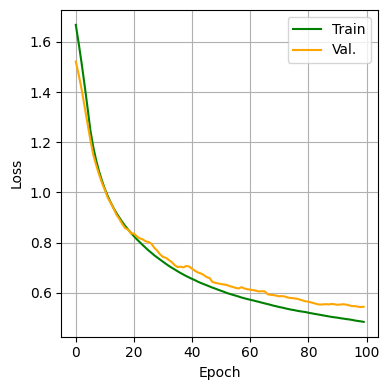

In [9]:
plot_learning_curves(history)

## 4) Prepare the Model for Pruning

To make a model "optimizable", it suffices to pass it to the PliNIO optimization method constructor (`PIT` in this example). The constructor internally implements the conversion steps necessary to generate the "searchable" network sketched in the figure above, replacing all Conv. and Linear layers with the respective mask-equipped versions, and handling all the necessary shape propagations to correctly estimate the DNN cost.

The constructor takes three main parameters:
- The previously created `nn.Module` of the "seed" DNN (better if already pre-trained, aka "warmed up")
- The shape of a single input sample (needed for internal graph analysis passes with `torch.fx`).
- A cost estimator, that is, the metric that we want to consider as "DNN cost". In this example, it will be the number of parameters (called `params` in PLiNIO). Other alternatives include the number of FLOPS (`ops` in PLiNIO) and hardware-dependent cost models for different targets. See the documentation for details.

In addition, we  also set the optional `discrete_cost=True`, which ensures that cost is estimated using the discretized version of the masks (i.e. $\theta$, rather than $\alpha$).



### Getting an Initial Cost Estimate 

PLiNIO optimizable models provide a `.cost` attribute that returns the current cost estimate for the model. Let's call the constructor and get the initial cost estimate:

In [10]:
pit_model = PIT(model, input_shape=input_shape, cost=params, discrete_cost=True)
pit_model = pit_model.to(device)
print(f"Estimated DNN cost: {pit_model.cost}")

Estimated DNN cost: 72762.0


Importantly, calling `.cost` on a PLiNIO model internally invokes a differentiable PyTorch function. Therefore, we can apply back-propagation to it (that is, we can use it as regularization term during training).

Numerically, you will see a cost that is *slightly lower* than the one computed by `torchinfo`. This is because, during the conversion implemented by the PIT constructor, Batch Normalization layers are folded with convolutions, which is necessary for the optimization to work.

### Looking at the Pruning Masks (Optional)

If you want, you can print the initial values of the PIT pruning masks with the following code. As you can see, each layer has a number of masks equal to its output channels, and all masks are initialized to 1.

In [11]:
with torch.no_grad():
    for p in pit_model.nas_parameters(): 
        print((torch.abs(p)>0.5).int().cpu().numpy())

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]


### Setting the Regularization Strength

Next, we have to set the value of $\lambda$ for the combined loss function equation shown at the top of the notebook. Unfortunately, there isn't a golden rule to choose this value. However, a good rule of thumb is to consider values so that:

$$
\lambda \cdot \mathcal{L_{cost}} \simeq \mathcal{L_{task}}
$$

Since our initial cost estimate is around 70k, and the final validation loss after warmup was roughly 0.5, values around $10^{-6}$ are a good choice. 

Normally, you would try different values around this range to obtain a Pareto frontier of models in the accuracy versus cost space. Alternatively, you can use a more advanced regulatization method such as [DUCCIO](https://ieeexplore.ieee.org/abstract/document/10278089), which PLiNIO also supports, to respect one or more cost constraints in one-shot.


In [12]:
TRAINING_CONFIG['reg_strength'] = 5e-06  # try different values too

## 5) Running the Optimization

We are now ready to run the pruning optimization loop.  For this, we will use two different optimizers for the DNN weights $W$ and for the mask parameters $\theta$. Part of the reason for this is that we should not apply *weight decay* to the mask parameters. Moreover, we may also want use a different type of optimizer (e.g. SGD vs Adam) and/or learning rate for the two parameter sets.

PLiNIO offers a convenient API to get only the normal DNN weights $W$, with the `model.net_parameters()` method, or only the NAS parameters $\theta$, with `model.nas_parameters()`. We use these two assign each optimizer to the correct parameters:

In [13]:
net_optimizer = torch.optim.Adam(pit_model.net_parameters(), lr=TRAINING_CONFIG['search_lr_net'], weight_decay=TRAINING_CONFIG['weight_decay'])
mask_optimizer = torch.optim.Adam(pit_model.nas_parameters(), lr=TRAINING_CONFIG['search_lr_mask'], weight_decay=0)

Lastly, let's define a modified training loop for the optimization. This is **very similar to a standard PyTorch training loop**, with a few key differences:

- It uses the two separate optimizers for $W$ and $\theta$ just created.
- It uses a modified loss function (`pruning_criterion`) that combines the two loss terms $\mathcal{L_{task}}$ and $\mathcal{L_{cost}}$ using the regularization strength $\lambda$, as detailed at the beginning of the notebook.
- In each epoch, we first train the $W$ on the training set, then train the $\theta$ on the **validation** set. This ensures that we select architectures that generalize well on data not included in the training set.

**IMPORTANT**: Note that using two separate optimizers is not necessary. If you want to share the optimizer for $W$ and $\theta$, you can make sure that the iteration on the training set only affects the $W$, and the one on the validation set only the $\theta$, using two utility functions in PLiNIO, respectively `train_net_only()` and `train_nas_only()`. These ensure that gradients are only propagated to DNN weights and NAS parameters respectively. There is also a third method `train_net_and_nas()` to enable gradient propagation to both sets of parameters simultaneously. When sharing the optimizer, also remember to apply weight decay only to the $W$ parameters passing a dictionary to a `torch.optim.Optimizer` as shown [here](https://pytorch.org/docs/stable/optim.html#per-parameter-options).

In [14]:
# pruning loop
def prune(checkpoint_path, patience, reg_strength, epochs, model, criterion, net_optimizer, mask_optimizer, 
          train_loader, val_loader, device):

    # define the pruning loss function
    def pruning_criterion(output, target):
        return criterion(output, target) + reg_strength * model.cost
    
    # Early stopping and checkpointing
    best_nas_loss = float('inf')
    epochs_without_improvement = 0

    history = []
    for epoch in range(epochs):
        # train weights on training set for one epoch
        metrics = train_one_epoch(epoch, model, criterion, net_optimizer, train_loader, device)
        
        # train masks on the VALIDATION set for one epoch
        n_metrics = train_one_epoch(epoch, model, pruning_criterion, mask_optimizer, val_loader, device)
        n_metrics = {'nas_' + k: v for k, v in n_metrics.items()}
        metrics.update(n_metrics)

        cost = model.cost.detach().cpu().numpy()
        print(f"Network cost after epoch {epoch+1} = {cost}")
        metrics['cost'] = cost
        history.append(metrics)

        # Check for improvement
        if metrics['nas_loss'] < best_nas_loss:
            best_nas_loss = metrics['nas_loss']
            epochs_without_improvement = 0
            torch.save(model.state_dict(), checkpoint_path)
            print("Saved new best model.")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break
    return history


Run the pruning loop:

In [15]:
checkpoint_path = SAVE_DIR / "search_best.pt"
criterion = nn.CrossEntropyLoss()

history = prune(checkpoint_path, TRAINING_CONFIG['patience'], TRAINING_CONFIG['reg_strength'], 
                TRAINING_CONFIG['search_epochs'], pit_model, criterion, net_optimizer, mask_optimizer,
                train_loader, val_loader, device)

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.29it/s, accuracy=77.1, loss=1.02]


Network cost after epoch 1 = 72762.0
Saved new best model.


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 45.90it/s, accuracy=77.2, loss=1.03]


Network cost after epoch 2 = 72762.0


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.40it/s, accuracy=77, loss=1.03]


Network cost after epoch 3 = 72762.0


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.36it/s, accuracy=78.3, loss=0.986]


Network cost after epoch 4 = 72762.0
Saved new best model.


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.13it/s, accuracy=79, loss=0.967]


Network cost after epoch 5 = 72762.0
Saved new best model.


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.37it/s, accuracy=78.3, loss=0.976]


Network cost after epoch 6 = 72762.0


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.68it/s, accuracy=78.3, loss=0.988]


Network cost after epoch 7 = 72762.0


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.76it/s, accuracy=79.6, loss=0.962]


Network cost after epoch 8 = 72762.0
Saved new best model.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.47it/s, accuracy=78.8, loss=0.969]


Network cost after epoch 9 = 70170.0


Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.65it/s, accuracy=79.3, loss=0.944]


Network cost after epoch 10 = 69306.0
Saved new best model.


Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.56it/s, accuracy=79.2, loss=0.933]


Network cost after epoch 11 = 66714.0
Saved new best model.


Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.24it/s, accuracy=78.8, loss=0.929]


Network cost after epoch 12 = 61530.0
Saved new best model.


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.44it/s, accuracy=78, loss=0.922]


Network cost after epoch 13 = 55482.0
Saved new best model.


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.88it/s, accuracy=77.8, loss=0.92]


Network cost after epoch 14 = 51162.0
Saved new best model.


Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.98it/s, accuracy=77.2, loss=0.909]


Network cost after epoch 15 = 46168.0
Saved new best model.


Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.60it/s, accuracy=76.3, loss=0.908]


Network cost after epoch 16 = 41264.0
Saved new best model.


Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.59it/s, accuracy=77.4, loss=0.849]


Network cost after epoch 17 = 39798.0
Saved new best model.


Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.10it/s, accuracy=76.8, loss=0.876]


Network cost after epoch 18 = 37719.0


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.22it/s, accuracy=77, loss=0.846]


Network cost after epoch 19 = 36882.0
Saved new best model.


Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.70it/s, accuracy=78.4, loss=0.815]


Network cost after epoch 20 = 36298.0
Saved new best model.


Epoch 21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.32it/s, accuracy=73.9, loss=0.919]


Network cost after epoch 21 = 30541.0


Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.84it/s, accuracy=75.2, loss=0.861]


Network cost after epoch 22 = 28476.0


Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.59it/s, accuracy=73.6, loss=0.895]


Network cost after epoch 23 = 25906.0


Epoch 24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.60it/s, accuracy=71.8, loss=0.924]


Network cost after epoch 24 = 21733.0


Epoch 25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.24it/s, accuracy=72.6, loss=0.899]


Network cost after epoch 25 = 19075.0


Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.37it/s, accuracy=72.3, loss=0.88]


Network cost after epoch 26 = 18355.0


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.76it/s, accuracy=73, loss=0.865]


Network cost after epoch 27 = 17801.0


Epoch 28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.85it/s, accuracy=71.4, loss=0.909]


Network cost after epoch 28 = 15416.0


Epoch 29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.71it/s, accuracy=72.7, loss=0.864]


Network cost after epoch 29 = 15039.0


Epoch 30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 46.81it/s, accuracy=71.5, loss=0.884]

Network cost after epoch 30 = 14383.0
Early stopping triggered after 30 epochs.


Let's see what happened during the optimization:

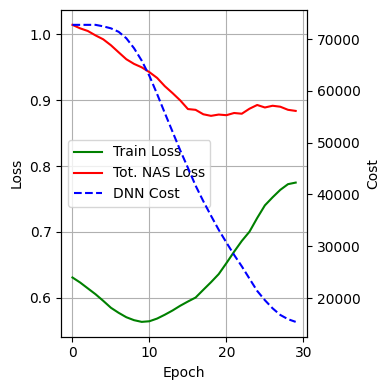

In [16]:
plot_learning_curves_nas(history)

### Evaluating the Pruned Model

Let's check the test accuracy of the pruned DNN after applying PIT:

In [17]:
pit_model.load_state_dict(torch.load(checkpoint_path))
pit_model.eval()

test_metrics = evaluate(pit_model, criterion, test_loader, device)
print(f'Final model cost: {pit_model.cost}, Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 123.95it/s, accuracy=77.9, loss=0.634]

Final model cost: 36298.0, Test Loss: 0.6335942637377654, Test Acc: 77.92999744415283


Depending on the regularization strength that you set, you should see that the cost (number of parameters) has reduced significantly, possibly at the cost of some accuracy degradation.

### Looking at the Masks After the Search (Optional)

If you look again at the $\theta$ parameters you have seen that they have changed thanks to the optimization.

In [18]:
with torch.no_grad():
    for p in pit_model.nas_parameters(): 
        print((torch.abs(p)>0.5).int().cpu().numpy())

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
[1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1]
[0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0
 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]


## 6) Final Model Export and Fine-Tuning

This model is still an instance of the `PIT` class. In order to obtain a standard `nn.Module` that we can use with any other torch-based tool (such as `torchinfo`), we can leverage  the `model.export()` API of PLiNIO.

In [19]:
final_model = pit_model.export()
final_model = final_model.to(device)

Let's look at the architecture of the optimized model using `torchinfo`.

In [20]:
print(summary(final_model, (1,) + input_shape, depth=5))

Layer (type:depth-idx)                   Output Shape              Param #
MiniResNet                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 32, 32]           432
├─BatchNorm2d: 1-2                       [1, 16, 32, 32]           32
├─ReLU: 1-3                              [1, 16, 32, 32]           --
├─Module: 1-4                            --                        --
│    └─Conv2d: 2-1                       [1, 31, 16, 16]           4,464
│    └─BatchNorm2d: 2-2                  [1, 31, 16, 16]           62
│    └─ReLU: 2-3                         [1, 31, 16, 16]           --
│    └─Conv2d: 2-4                       [1, 28, 16, 16]           7,812
│    └─BatchNorm2d: 2-5                  [1, 28, 16, 16]           56
│    └─Module: 2-6                       --                        --
│    │    └─Conv2d: 3-1                  [1, 28, 16, 16]           448
│    │    └─BatchNorm2d: 3-2             [1, 28, 16, 16]           56
│    └─

You will see that the number of channels in some layers has changed as an effect of pruning, and thus the total model size has reduced.

In case of the PIT algorithm, fine-tuning the exported model for some epochs is *very important*. This is because, in the same way that PIT *folds* BatchNorm layers before the search, it *unfolds* them when exporting the final model, to guarantee that it has exactly the same architecture of the input (except for the pruned channels).

You can verify this by testing the model just after export. You will see the accuracy drop significantly. However, few epochs of fine-tuning should suffice to recover the drop, and possibly even improve the final accuracy (thanks to BatchNorm). 

Let's fine-tune with the original training code from Part 2 above:

In [21]:
checkpoint_path = SAVE_DIR / "finetune_best.pt"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(final_model.parameters(), lr=TRAINING_CONFIG['lr'], weight_decay=TRAINING_CONFIG['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TRAINING_CONFIG['epochs'])

history = train(checkpoint_path, TRAINING_CONFIG['patience'], TRAINING_CONFIG['epochs'], final_model, criterion, optimizer, scheduler,
      train_loader, val_loader, device)

Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.11it/s, accuracy=76.5, loss=0.721]


Saved new best model.


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.94it/s, accuracy=77, loss=0.664]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 97.77it/s, accuracy=78.1, loss=0.639]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.60it/s, accuracy=79.1, loss=0.614]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.11it/s, accuracy=79.9, loss=0.591]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.94it/s, accuracy=79.6, loss=0.591]


Saved new best model.


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.43it/s, accuracy=79.8, loss=0.59]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.43it/s, accuracy=80.3, loss=0.577]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.37it/s, accuracy=79.9, loss=0.576]


Saved new best model.


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.44it/s, accuracy=80, loss=0.576]


Saved new best model.


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.46it/s, accuracy=80.5, loss=0.56]


Saved new best model.


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 97.47it/s, accuracy=81, loss=0.555]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 97.36it/s, accuracy=80.9, loss=0.552]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.14it/s, accuracy=80.8, loss=0.551]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.33it/s, accuracy=81.4, loss=0.545]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.43it/s, accuracy=81.4, loss=0.542]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 97.82it/s, accuracy=81.6, loss=0.538]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 93.72it/s, accuracy=81.2, loss=0.535]


Saved new best model.


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.52it/s, accuracy=82, loss=0.527]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 97.14it/s, accuracy=81.7, loss=0.521]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.76it/s, accuracy=81.9, loss=0.518]


Saved new best model.


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.59it/s, accuracy=82, loss=0.517]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.92it/s, accuracy=82.3, loss=0.513]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.48it/s, accuracy=82.4, loss=0.509]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.17it/s, accuracy=82.8, loss=0.505]


Saved new best model.


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 97.96it/s, accuracy=82.2, loss=0.515]

Early stopping triggered after 83 epochs.


Finally, let's evaluate our optimized model on the test set:

In [22]:
test_metrics = evaluate(final_model, criterion, test_loader, device)
print(f'Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 138.97it/s, accuracy=82.3, loss=0.536]

Test Loss: 0.5362657111959336, Test Acc: 82.260000705719
